In [1]:
import numpy as np
import pandas as pd
import quantecon as qe
from ast import literal_eval
from sklearn.ensemble import RandomForestRegressor
import ternary

In [2]:
def creating_samples(samples_number, element):
    gen=0
    uniform_number = len(element)
    uniform_samples = (-qe.simplex_grid(len(element), 1)+1)/(len(element)-1)
    if samples_number > uniform_number:
        random_samples = np.random.rand((samples_number-uniform_number), len(element))
        for i in range(samples_number-uniform_number):
            random_samples[i] = np.around(random_samples[i]/sum(random_samples[i]), decimals = 3)
        sample = np.vstack((uniform_samples, random_samples))
    else:
        sample = uniform_samples[:samples_number]
    samples = []
    for i in range(samples_number):
        samples.append(list(sample[i]))
    samples = np.array(samples)
    generation = []
    for i in range (samples_number):
            generation.append(gen)

    ID = np.arange(1, (samples_number+1))

    data = {'ID' : ID, 'Elements': [element], 'Generation': generation}
    df = pd.DataFrame(data=data, index = np.arange(samples_number))
    df = pd.concat([df, pd.DataFrame(([[i] for i in samples]), columns = ['Position'])], axis = 1)
    df.to_csv("Result/Initial Population.txt", sep='\t', index=False, mode='w')
    return df

In [3]:
#Loading data and fitting
df_old = pd.read_csv('Data/AuIrOsPdPtReRhRu_0.60_compositions_and_targets.csv')
X_columns_old = ['Pt','Pd','Au','Ru','Rh','Ir','Re','Os']
x_old = df_old[X_columns_old].to_numpy()
y_old = df_old['current_over_capacitance'].to_numpy()

#Rndom Forest Regression
reg = RandomForestRegressor(n_estimators = 1024,
                           bootstrap = True,
                           max_depth = None,
                           max_features = 'auto',
                           min_samples_leaf = 1,
                           min_samples_split = 2,
                           oob_score = True)
reg = reg.fit(x_old, y_old)

In [4]:
#Determine the best position
grid = qe.simplex_grid(3, 1000)/1000
zeros = np.zeros(len(grid)).reshape(-1,1)

grid = np.concatenate((grid, zeros), axis=1)
grid = np.concatenate((grid, zeros), axis=1)
grid = np.concatenate((grid, zeros), axis=1)
grid = np.concatenate((grid, zeros), axis=1)
grid = np.concatenate((grid, zeros), axis=1)
grid = pd.DataFrame(grid,columns=[X_columns_old])
grid['Activity'] = reg.predict(grid.to_numpy())
best_grid = grid.iloc[np.argmin(grid['Activity'])][0:3].to_numpy()

In [5]:
print(best_grid, grid.iloc[np.argmin(grid['Activity'])]['Activity'])

[0.397 0.294 0.309] -1.042216416015624


In [35]:
#Making Class
class pso:
    def __init__ (self, data, step, target = np.array([0.333, 0.333, 0.333])):
        self.datalog = data
        #Reading "Elements" columns from string to list
        self.datalog['Elements'] = self.datalog["Elements"].apply(lambda x: literal_eval(x))
        
        #Select latest generation
        self.generation = self.datalog['Generation'].max()
        
        #Creating np.array of "Position" column and dropping the string type "Position" column
        self.position = []
        for i in range(self.datalog['ID'].max()):
            self.position.append(list(np.fromstring(self.datalog['Position'][i][1:-1], dtype=float, sep=' ')))
        self.position = np.array(self.position)
        self.datalog = self.datalog.drop(columns=['Position'])
        self.datalog = pd.concat([self.datalog, pd.DataFrame(([[i] for i in self.position]), columns = ['Position'])], axis = 1)
        
        #Creating "Velocity" column for the "0" generation
        if self.generation == 0:
            self.velocity = np.around((-(self.position - target)/step), decimals = 3)
            self.datalog = pd.concat([self.datalog, pd.DataFrame(([[i] for i in self.velocity]), columns = ['Velocity'])], axis = 1)

        
        #Creating blank "Activity" column
        self.datalog = pd.concat([self.datalog, pd.DataFrame(columns = ['Activity'], index = np.arange(self.datalog['ID'].max()))], axis = 1)      

        #Filling the "Activity" column with RFR
        self.f_activity(self.datalog)
            
        #Creating dataframe of the latest generation
        self.working_generation = self.datalog.loc[self.datalog['Generation']==self.generation]
    
    
            
    def move(self, factor_1, factor_2, factor_3, mutation_rate, mutation_prob):
        #Performing move function  
        self.generation += 1
        self.working_generation['Generation'] += 1
        
        #Creating new velocity
        for i in range(len(self.working_generation)):
            new_velocity = -(factor_1 * population.working_generation.at[i, 'Velocity'] + 
                        factor_2 * population.delta_gen_best((i+1), 'Activity') * population.delta_gen_best((i+1), 'Position') + 
                        factor_3 * population.delta_individual_best((i+1), 'Activity') * population.delta_individual_best((i+1), 'Position'))
            #Mutation process
            self.working_generation.at[i,'Velocity'] = self.mutate(new_velocity, mutation_rate, mutation_prob)
        #Normalization
        self.normalize_velocity()
            
        #Changing position
        for i in range(len(self.working_generation)):    
            new_position = self.working_generation['Position'][i] + self.working_generation['Velocity'][i]
            self.working_generation.at[i,'Position'] = np.around(new_position, decimals = 3)
        #Normalization
        self.normalize_position()    
            
            
        """#Checking whether the new position cross the boundaries (UNFINISHED)
        if new_position.max() > 1 or new_position.min() < 0:
            new_position = self.working_generation['Position'][i] - self.working_generation['Velocity'][i]*size
        self.working_generation.at[i,'Position'] = np.around(new_position, decimals = 3)"""
        
        
        #Filling the "Activity" column with RFR
        self.f_activity(self.working_generation)
        
        #Concating the tables
        self.datalog = pd.concat([self.datalog, self.working_generation])
        self.datalog = self.datalog.reset_index(drop=True)
        self.store_datalog()
        return
    
    def f_activity(self, dataframe):
        global reg
        a = [0, 0, 0, 0, 0]
        for i in range(len(dataframe)):
            dataframe.at[i, 'Activity'] = float(reg.predict(np.reshape((np.hstack((dataframe.at[i, 'Position'], a))), (1, -1))))
        return 

    def store_datalog(self):
        self.datalog.to_csv("Result/Initial Population_gen "+str(self.generation)+".txt", sep='\t', index=False, mode='w')
        return
    
    def normalize_velocity(self):
        for i in range(len(self.working_generation)):
            self.working_generation.at[i, 'Velocity'] = self.working_generation.at[i, 'Velocity'] - (sum(self.working_generation.at[i, 'Velocity'])/len(self.working_generation['Elements'][0]))
            self.working_generation.at[i, 'Velocity'] = np.around(self.working_generation.at[i, 'Velocity'], decimals= 3)
        return
    
    def normalize_position(self):
        for i in range(len(self.working_generation)):
            if self.working_generation.at[i, 'Position'].min() < 0:
                self.working_generation.at[i, 'Position'] = self.working_generation.at[i, 'Position'] - self.working_generation.at[i, 'Position'].min()
            self.working_generation.at[i, 'Position'] = self.working_generation.at[i, 'Position']/(sum(self.working_generation.at[i, 'Position']))
            self.working_generation.at[i, 'Position'] = np.around(self.working_generation.at[i, 'Position'], decimals= 3)
        return 
    
    def g_best(self):
        return self.datalog.loc[np.argmin(self.datalog['Activity'])]
    
    def gen_best(self):
        return self.working_generation.loc[np.argmin(self.working_generation['Activity'])]
           
   
    def individual_best(self, ID):
        self.i_data = self.datalog[self.datalog['ID']==ID].reset_index(drop=True)
        return self.i_data.loc[np.argmin(self.i_data['Activity'])]
    
    def delta_gen_best(self, ID, parameter):
        return self.working_generation[self.working_generation['ID']==ID][parameter].reset_index(drop=True)[0] - self.gen_best()[parameter]
    
    def delta_individual_best(self, ID, parameter):
        return self.working_generation[self.working_generation['ID']==ID][parameter].reset_index(drop=True)[0] - self.individual_best(ID)[parameter]      
    
    def mutate(self, new_velocity, mutation_rate, mutation_prob):
        mutated_velocity = []
        for i in range(len(new_velocity)):
            mutation = np.random.rand()
            step_size_i = 1
            if mutation < mutation_prob:
                step_size_i = np.random.uniform((1-mutation_rate), (1+mutation_rate))
            mutated_velocity.append(new_velocity[i]*step_size_i)
        mutated_velocity = np.array(mutated_velocity)
        return mutated_velocity
    
    def individual_log(self, ID):
        return self.datalog[self.datalog['ID']==ID].reset_index(drop=True)
    
    
    def plot(self):
        self.points = []
        for i in range(len(self.working_generation)):
            for x in range(self.generation+1):
                self.points.append(tuple(self.individual_log(i+1)['Position'][x]))
        scale = 1
        figure, tax = ternary.figure(scale=scale)
        figure.set_size_inches(10, 10)

        # Plot a few different styles with a legend
        tax.scatter(self.points[(population.generation+1)*0 : (population.generation+1)*1], marker='*', color='magenta', label="ID = 1")
        tax.scatter(self.points[(population.generation+1)*1 : (population.generation+1)*2], marker='*', color='green', label="ID = 2")
        tax.scatter(self.points[(population.generation+1)*2 : (population.generation+1)*3], marker='*', color='blue', label="ID = 3")
        tax.scatter(self.points[(population.generation+1)*3 : (population.generation+1)*4], marker='*', color='red', label="ID = 4")
        tax.scatter(self.points[(population.generation+1)*4 : (population.generation+1)*5], marker='*', color='black', label="ID = 5")
        tax.scatter(self.points[(population.generation+1)*5 : (population.generation+1)*6], marker='*', color='grey', label="ID = 6")
        tax.legend()

        tax.set_title("Scatter Plot", fontsize=20)
        tax.boundary(linewidth=1.0)
        tax.gridlines(multiple=0.1, color="blue")
        tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats="%.1f")
        tax.clear_matplotlib_ticks()
        tax.get_axes().axis('off')
        tax.show() 
        return 

In [36]:
samples_number = 6
element = ['Pt', 'Pd', 'Au']
creating_samples(samples_number, element)

,ID,Elements,Generation,Position
0,1,"[Pt, Pd, Au]",0,"[0.5, 0.5, 0.0]"
1,2,"[Pt, Pd, Au]",0,"[0.5, 0.0, 0.5]"
2,3,"[Pt, Pd, Au]",0,"[0.0, 0.5, 0.5]"
3,4,"[Pt, Pd, Au]",0,"[0.094, 0.592, 0.314]"
4,5,"[Pt, Pd, Au]",0,"[0.211, 0.328, 0.46]"
5,6,"[Pt, Pd, Au]",0,"[0.177, 0.565, 0.258]"


In [51]:
step = 5
target = np.array([0.333, 0.333, 0.333])
population = pso(pd.read_csv('Result/Initial Population.txt', sep='\t'), step, target)

In [52]:
population.datalog

,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",0,"[0.5, 0.5, 0.0]","[-0.033, -0.033, 0.067]",-0.940136
1,2,"[Pt, Pd, Au]",0,"[0.5, 0.0, 0.5]","[-0.033, 0.067, -0.033]",-0.918508
2,3,"[Pt, Pd, Au]",0,"[0.0, 0.5, 0.5]","[0.067, -0.033, -0.033]",-0.285533
3,4,"[Pt, Pd, Au]",0,"[0.094, 0.592, 0.314]","[0.048, -0.052, 0.004]",-0.725978
4,5,"[Pt, Pd, Au]",0,"[0.211, 0.328, 0.46]","[0.024, 0.001, -0.025]",-0.953033
5,6,"[Pt, Pd, Au]",0,"[0.177, 0.565, 0.258]","[0.031, -0.046, 0.015]",-0.979853


In [53]:
factor_1 = 0.95
factor_2 = 0.6
factor_3 = 0.7
mutation_prob = 0.7
mutation_rate = 0.7

for i in range(20):
    population.move(factor_1, factor_2, factor_3, mutation_prob, mutation_rate)
    display(population.working_generation)
    print(population.g_best()['Position'], population.g_best()['Activity'])
    print(np.sqrt(sum((population.g_best()['Position']-best_grid)**2)))

,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",1,"[0.498, 0.502, 0.0]","[0.032, 0.038, -0.07]",-0.940136
1,2,"[Pt, Pd, Au]",1,"[0.496, 0.0, 0.504]","[0.019, -0.045, 0.027]",-0.918508
2,3,"[Pt, Pd, Au]",1,"[0.02, 0.562, 0.418]","[0.02, 0.062, -0.082]",-0.290212
3,4,"[Pt, Pd, Au]",1,"[0.063, 0.633, 0.304]","[-0.031, 0.041, -0.01]",-0.316155
4,5,"[Pt, Pd, Au]",1,"[0.185, 0.332, 0.482]","[-0.026, 0.004, 0.022]",-0.966667
5,6,"[Pt, Pd, Au]",1,"[0.158, 0.6, 0.242]","[-0.019, 0.036, -0.016]",-0.911996


[0.177 0.565 0.258] -0.979853134765623
0.3527633767839286


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",2,"[0.479, 0.45, 0.071]","[-0.019, -0.052, 0.071]",-0.946459
1,2,"[Pt, Pd, Au]",2,"[0.482, 0.033, 0.485]","[-0.014, 0.033, -0.019]",-0.918884
2,3,"[Pt, Pd, Au]",2,"[0.066, 0.426, 0.508]","[0.046, -0.136, 0.09]",-0.318143
3,4,"[Pt, Pd, Au]",2,"[0.137, 0.471, 0.392]","[0.074, -0.162, 0.088]",-0.787873
4,5,"[Pt, Pd, Au]",2,"[0.21, 0.328, 0.462]","[0.025, -0.005, -0.021]",-0.953089
5,6,"[Pt, Pd, Au]",2,"[0.164, 0.573, 0.263]","[0.006, -0.027, 0.021]",-0.915625


[0.177 0.565 0.258] -0.979853134765623
0.3527633767839286


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",3,"[0.506, 0.479, 0.015]","[0.027, 0.029, -0.056]",-0.939904
1,2,"[Pt, Pd, Au]",3,"[0.487, 0.015, 0.499]","[0.005, -0.018, 0.014]",-0.918508
2,3,"[Pt, Pd, Au]",3,"[0.08, 0.536, 0.384]","[0.014, 0.11, -0.124]",-0.639045
3,4,"[Pt, Pd, Au]",3,"[0.045, 0.668, 0.287]","[-0.092, 0.197, -0.105]",-0.313133
4,5,"[Pt, Pd, Au]",3,"[0.187, 0.334, 0.479]","[-0.023, 0.006, 0.017]",-0.965645
5,6,"[Pt, Pd, Au]",3,"[0.161, 0.591, 0.248]","[-0.003, 0.018, -0.015]",-0.917484


[0.177 0.565 0.258] -0.979853134765623
0.3527633767839286


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",4,"[0.472, 0.444, 0.084]","[-0.034, -0.035, 0.069]",-0.946969
1,2,"[Pt, Pd, Au]",4,"[0.471, 0.042, 0.488]","[-0.016, 0.027, -0.011]",-0.919563
2,3,"[Pt, Pd, Au]",4,"[0.102, 0.309, 0.589]","[0.022, -0.227, 0.204]",-0.75668
3,4,"[Pt, Pd, Au]",4,"[0.204, 0.141, 0.655]","[0.159, -0.527, 0.368]",-0.823895
4,5,"[Pt, Pd, Au]",4,"[0.212, 0.322, 0.466]","[0.025, -0.012, -0.013]",-0.959413
5,6,"[Pt, Pd, Au]",4,"[0.165, 0.574, 0.261]","[0.004, -0.017, 0.013]",-0.917233


[0.177 0.565 0.258] -0.979853134765623
0.3527633767839286


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",5,"[0.494, 0.474, 0.032]","[0.022, 0.03, -0.052]",-0.940631
1,2,"[Pt, Pd, Au]",5,"[0.478, 0.023, 0.5]","[0.007, -0.019, 0.012]",-0.918958
2,3,"[Pt, Pd, Au]",5,"[0.06, 0.577, 0.363]","[-0.042, 0.267, -0.226]",-0.315866
3,4,"[Pt, Pd, Au]",5,"[0.054, 0.685, 0.261]","[-0.15, 0.544, -0.394]",-0.313544
4,5,"[Pt, Pd, Au]",5,"[0.196, 0.326, 0.478]","[-0.016, 0.004, 0.012]",-0.966036
5,6,"[Pt, Pd, Au]",5,"[0.162, 0.582, 0.256]","[-0.003, 0.009, -0.005]",-0.916276


[0.177 0.565 0.258] -0.979853134765623
0.3527633767839286


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",6,"[0.462, 0.456, 0.083]","[-0.032, -0.018, 0.051]",-0.946969
1,2,"[Pt, Pd, Au]",6,"[0.475, 0.035, 0.491]","[-0.003, 0.012, -0.009]",-0.918884
2,3,"[Pt, Pd, Au]",6,"[0.095, 0.071, 0.834]","[0.035, -0.506, 0.471]",-0.660739
3,4,"[Pt, Pd, Au]",6,"[0.471, 0.0, 0.529]","[0.466, -0.804, 0.338]",-0.918508
4,5,"[Pt, Pd, Au]",6,"[0.213, 0.324, 0.463]","[0.017, -0.002, -0.015]",-0.950774
5,6,"[Pt, Pd, Au]",6,"[0.166, 0.569, 0.265]","[0.004, -0.013, 0.009]",-0.915625


[0.177 0.565 0.258] -0.979853134765623
0.3527633767839286


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",7,"[0.48, 0.467, 0.054]","[0.018, 0.011, -0.029]",-0.944563
1,2,"[Pt, Pd, Au]",7,"[0.472, 0.03, 0.499]","[-0.003, -0.005, 0.008]",-0.918845
2,3,"[Pt, Pd, Au]",7,"[0.09, 0.261, 0.649]","[-0.005, 0.19, -0.184]",-0.715966
3,4,"[Pt, Pd, Au]",7,"[0.023, 0.77, 0.207]","[-0.448, 0.77, -0.322]",-0.284397
4,5,"[Pt, Pd, Au]",7,"[0.197, 0.328, 0.476]","[-0.016, 0.004, 0.013]",-0.966067
5,6,"[Pt, Pd, Au]",7,"[0.165, 0.574, 0.261]","[-0.001, 0.006, -0.004]",-0.917233


[0.177 0.565 0.258] -0.979853134765623
0.3527633767839286


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",8,"[0.449, 0.461, 0.091]","[-0.031, -0.006, 0.037]",-0.953486
1,2,"[Pt, Pd, Au]",8,"[0.465, 0.042, 0.494]","[-0.007, 0.012, -0.005]",-0.919563
2,3,"[Pt, Pd, Au]",8,"[0.077, 0.058, 0.865]","[-0.013, -0.203, 0.215]",-0.42823
3,4,"[Pt, Pd, Au]",8,"[0.221, 0.167, 0.612]","[0.198, -0.603, 0.404]",-0.828695
4,5,"[Pt, Pd, Au]",8,"[0.214, 0.327, 0.459]","[0.017, -0.0, -0.016]",-0.950198
5,6,"[Pt, Pd, Au]",8,"[0.166, 0.56, 0.274]","[0.001, -0.014, 0.013]",-0.915404


[0.177 0.565 0.258] -0.979853134765623
0.3527633767839286


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",9,"[0.471, 0.462, 0.067]","[0.023, 0.002, -0.024]",-0.946459
1,2,"[Pt, Pd, Au]",9,"[0.471, 0.038, 0.491]","[0.006, -0.004, -0.003]",-0.918884
2,3,"[Pt, Pd, Au]",9,"[0.255, 0.327, 0.419]","[0.178, 0.269, -0.446]",-0.961518
3,4,"[Pt, Pd, Au]",9,"[0.036, 0.761, 0.203]","[-0.185, 0.594, -0.409]",-0.294682
4,5,"[Pt, Pd, Au]",9,"[0.203, 0.325, 0.472]","[-0.011, -0.002, 0.013]",-0.954624
5,6,"[Pt, Pd, Au]",9,"[0.167, 0.573, 0.26]","[0.001, 0.013, -0.014]",-0.917586


[0.177 0.565 0.258] -0.979853134765623
0.3527633767839286


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",10,"[0.453, 0.462, 0.085]","[-0.018, 0.0, 0.018]",-0.946892
1,2,"[Pt, Pd, Au]",10,"[0.461, 0.046, 0.493]","[-0.01, 0.008, 0.002]",-0.919563
2,3,"[Pt, Pd, Au]",10,"[0.107, 0.282, 0.611]","[-0.148, -0.044, 0.193]",-0.752949
3,4,"[Pt, Pd, Au]",10,"[0.471, 0.0, 0.529]","[0.559, -1.059, 0.5]",-0.918508
4,5,"[Pt, Pd, Au]",10,"[0.216, 0.329, 0.455]","[0.013, 0.004, -0.017]",-0.950198
5,6,"[Pt, Pd, Au]",10,"[0.17, 0.556, 0.274]","[0.003, -0.017, 0.014]",-0.935861


[0.177 0.565 0.258] -0.979853134765623
0.3527633767839286


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",11,"[0.463, 0.465, 0.071]","[0.01, 0.003, -0.014]",-0.946459
1,2,"[Pt, Pd, Au]",11,"[0.467, 0.043, 0.49]","[0.006, -0.003, -0.003]",-0.919563
2,3,"[Pt, Pd, Au]",11,"[0.231, 0.374, 0.396]","[0.124, 0.092, -0.215]",-0.941789
3,4,"[Pt, Pd, Au]",11,"[0.0, 0.731, 0.269]","[-0.494, 0.758, -0.265]",-0.286853
4,5,"[Pt, Pd, Au]",11,"[0.199, 0.323, 0.478]","[-0.017, -0.006, 0.023]",-0.957275
5,6,"[Pt, Pd, Au]",11,"[0.164, 0.575, 0.261]","[-0.006, 0.019, -0.013]",-0.917233


[0.177 0.565 0.258] -0.979853134765623
0.3527633767839286


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",12,"[0.451, 0.461, 0.087]","[-0.012, -0.004, 0.016]",-0.952833
1,2,"[Pt, Pd, Au]",12,"[0.455, 0.052, 0.493]","[-0.012, 0.009, 0.003]",-0.920042
2,3,"[Pt, Pd, Au]",12,"[0.1, 0.286, 0.614]","[-0.131, -0.088, 0.219]",-0.744159
3,4,"[Pt, Pd, Au]",12,"[0.55, 0.0, 0.45]","[0.931, -1.317, 0.386]",-0.918508
4,5,"[Pt, Pd, Au]",12,"[0.206, 0.328, 0.466]","[0.007, 0.005, -0.012]",-0.953089
5,6,"[Pt, Pd, Au]",12,"[0.177, 0.546, 0.277]","[0.013, -0.029, 0.016]",-0.977256


[0.177 0.565 0.258] -0.979853134765623
0.3527633767839286


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",13,"[0.461, 0.467, 0.071]","[0.01, 0.006, -0.016]",-0.946459
1,2,"[Pt, Pd, Au]",13,"[0.457, 0.06, 0.483]","[0.002, 0.008, -0.01]",-0.921321
2,3,"[Pt, Pd, Au]",13,"[0.166, 0.51, 0.324]","[0.066, 0.223, -0.29]",-0.913366
3,4,"[Pt, Pd, Au]",13,"[0.012, 0.988, 0.0]","[-0.842, 1.608, -0.765]",-0.285511
4,5,"[Pt, Pd, Au]",13,"[0.199, 0.325, 0.476]","[-0.007, -0.003, 0.01]",-0.957275
5,6,"[Pt, Pd, Au]",13,"[0.163, 0.583, 0.254]","[-0.014, 0.037, -0.023]",-0.919078


[0.177 0.565 0.258] -0.979853134765623
0.3527633767839286


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",14,"[0.444, 0.457, 0.098]","[-0.017, -0.01, 0.027]",-0.951826
1,2,"[Pt, Pd, Au]",14,"[0.45, 0.058, 0.492]","[-0.007, -0.002, 0.009]",-0.92131
2,3,"[Pt, Pd, Au]",14,"[0.085, 0.298, 0.617]","[-0.081, -0.212, 0.293]",-0.697552
3,4,"[Pt, Pd, Au]",14,"[0.462, 0.0, 0.538]","[1.329, -3.269, 1.939]",-0.918508
4,5,"[Pt, Pd, Au]",14,"[0.205, 0.33, 0.465]","[0.006, 0.005, -0.011]",-0.953911
5,6,"[Pt, Pd, Au]",14,"[0.177, 0.538, 0.285]","[0.014, -0.045, 0.031]",-0.975805


[0.177 0.565 0.258] -0.979853134765623
0.3527633767839286


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",15,"[0.452, 0.471, 0.076]","[0.008, 0.014, -0.022]",-0.946246
1,2,"[Pt, Pd, Au]",15,"[0.45, 0.066, 0.484]","[0.0, 0.008, -0.008]",-0.921334
2,3,"[Pt, Pd, Au]",15,"[0.277, 0.474, 0.249]","[0.192, 0.176, -0.368]",-0.982117
3,4,"[Pt, Pd, Au]",15,"[0.207, 0.793, 0.0]","[-1.184, 4.163, -2.979]",-0.875734
4,5,"[Pt, Pd, Au]",15,"[0.199, 0.328, 0.473]","[-0.006, -0.002, 0.008]",-0.956699
5,6,"[Pt, Pd, Au]",15,"[0.17, 0.568, 0.262]","[-0.007, 0.03, -0.023]",-0.937567


[0.277 0.474 0.249] -0.9821174999999992
0.22449944320643647


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",16,"[0.442, 0.458, 0.1]","[-0.011, -0.014, 0.024]",-0.949552
1,2,"[Pt, Pd, Au]",16,"[0.444, 0.073, 0.483]","[-0.006, 0.007, -0.001]",-0.921371
2,3,"[Pt, Pd, Au]",16,"[0.076, 0.288, 0.636]","[-0.201, -0.186, 0.388]",-0.469041
3,4,"[Pt, Pd, Au]",16,"[0.521, 0.0, 0.479]","[2.231, -4.202, 1.971]",-0.918508
4,5,"[Pt, Pd, Au]",16,"[0.207, 0.332, 0.461]","[0.008, 0.004, -0.012]",-0.953089
5,6,"[Pt, Pd, Au]",16,"[0.171, 0.546, 0.283]","[0.001, -0.022, 0.021]",-0.937445


[0.277 0.474 0.249] -0.9821174999999992
0.22449944320643647


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",17,"[0.447, 0.473, 0.08]","[0.005, 0.015, -0.02]",-0.946246
1,2,"[Pt, Pd, Au]",17,"[0.445, 0.071, 0.484]","[0.001, -0.002, 0.001]",-0.921371
2,3,"[Pt, Pd, Au]",17,"[0.282, 0.464, 0.254]","[0.206, 0.176, -0.382]",-0.982316
3,4,"[Pt, Pd, Au]",17,"[0.005, 0.995, 0.0]","[-1.787, 3.555, -1.768]",-0.281213
4,5,"[Pt, Pd, Au]",17,"[0.197, 0.331, 0.473]","[-0.01, -0.001, 0.012]",-0.966067
5,6,"[Pt, Pd, Au]",17,"[0.167, 0.562, 0.271]","[-0.004, 0.016, -0.012]",-0.915919


[0.282 0.464 0.254] -0.982315937499999
0.21248529360875784


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",18,"[0.433, 0.454, 0.113]","[-0.014, -0.019, 0.033]",-0.949552
1,2,"[Pt, Pd, Au]",18,"[0.44, 0.079, 0.481]","[-0.005, 0.008, -0.003]",-0.921162
2,3,"[Pt, Pd, Au]",18,"[0.115, 0.288, 0.597]","[-0.167, -0.176, 0.343]",-0.757607
3,4,"[Pt, Pd, Au]",18,"[0.55, 0.0, 0.45]","[3.228, -5.118, 1.89]",-0.918508
4,5,"[Pt, Pd, Au]",18,"[0.21, 0.332, 0.459]","[0.013, 0.001, -0.014]",-0.953089
5,6,"[Pt, Pd, Au]",18,"[0.177, 0.54, 0.283]","[0.01, -0.022, 0.012]",-0.975431


[0.282 0.464 0.254] -0.982315937499999
0.21248529360875784


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",19,"[0.447, 0.469, 0.084]","[0.014, 0.015, -0.029]",-0.946969
1,2,"[Pt, Pd, Au]",19,"[0.437, 0.088, 0.475]","[-0.003, 0.009, -0.006]",-0.924971
2,3,"[Pt, Pd, Au]",19,"[0.307, 0.516, 0.177]","[0.192, 0.227, -0.42]",-0.913726
3,4,"[Pt, Pd, Au]",19,"[0.0, 0.802, 0.198]","[-4.83, 6.82, -1.99]",-0.279547
4,5,"[Pt, Pd, Au]",19,"[0.19, 0.334, 0.477]","[-0.02, 0.002, 0.018]",-0.964325
5,6,"[Pt, Pd, Au]",19,"[0.168, 0.561, 0.271]","[-0.009, 0.021, -0.012]",-0.919258


[0.282 0.464 0.254] -0.982315937499999
0.21248529360875784


,ID,Elements,Generation,Position,Velocity,Activity
0,1,"[Pt, Pd, Au]",20,"[0.426, 0.456, 0.118]","[-0.021, -0.013, 0.034]",-0.950092
1,2,"[Pt, Pd, Au]",20,"[0.435, 0.085, 0.48]","[-0.002, -0.003, 0.005]",-0.924208
2,3,"[Pt, Pd, Au]",20,"[0.213, 0.283, 0.504]","[-0.094, -0.233, 0.327]",-0.935583
3,4,"[Pt, Pd, Au]",20,"[0.536, 0.0, 0.464]","[5.562, -9.05, 3.488]",-0.918508
4,5,"[Pt, Pd, Au]",20,"[0.21, 0.329, 0.462]","[0.02, -0.005, -0.015]",-0.953089
5,6,"[Pt, Pd, Au]",20,"[0.171, 0.534, 0.295]","[0.003, -0.027, 0.024]",-0.938082


[0.282 0.464 0.254] -0.982315937499999
0.21248529360875784


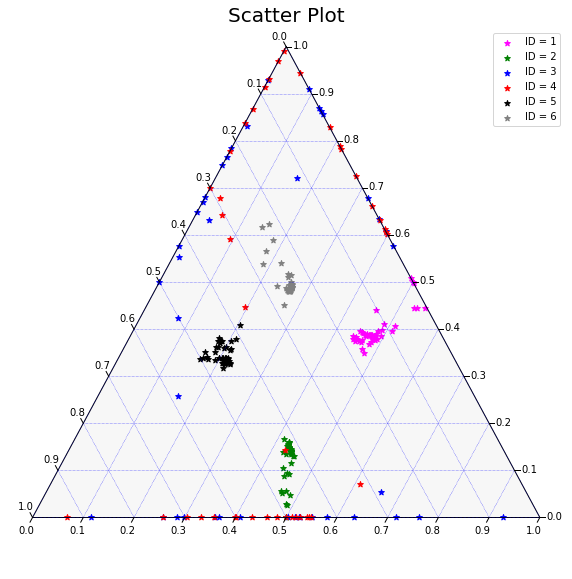

In [50]:
population.plot()